## The Back-substitution Algorithm for Finding a Null Basis

**Theorem:** Let $A$ be an $m$-by-$n$ matrix with full row rank $m$, and write the LU decomposition $PAQ = L[U_1~~U_2]$. If $Q$ is such that $U_1$ is nonsingular, then 

$$
B = Q\begin{bmatrix} -U_1^{-1}U_2 \\ I \end{bmatrix}
$$

is a basis for the null space of $A$.

**Proof:** $B$ is a basis for the null space of $A$ if and only if $AB = 0$. Suppose $PAQ = L[U_1~~U_2]$.

$$
\begin{align}
L(-U_2 + U_2) &= 0 \\
L(-U_1U_1^{-1}U_2 +U_2) &= 0 &\text{multiply by identity} \\
L\begin{bmatrix}U_1 & U_2\end{bmatrix} \begin{bmatrix} -U_1^{-1}U_2 \\ I \end{bmatrix} &= 0 &\text{express as inner product} \\
PAQ\begin{bmatrix} -U_1^{-1}U_2 \\ I \end{bmatrix} &= 0 &\text{by supposition} \\
PAB &= 0 &\text{definition of }B \\
AB &= 0 &\text{multiply by permutation matrix }P^{-1}
\end{align}
$$

## Application to Temporal Instanton Analysis

A speedy implementation of the back-substitution algorithm calls for a full-pivot LU decomposition that promotes sparsity.

Let $AQ = [A_1~~A_2]$, where $Q$ is such that $A_1$ is square and nonsingular. Now perform LU decomposition to obtain

$$
\begin{align}
P_1A_1Q_1 &= LU_1
\end{align}
$$

with full pivoting to obtain

$$
\begin{align}
P_1A_1Q_1 &= LU_1
\end{align}
$$

Begin by sorting columns of $A$ so that $A_1$ is nonsingular.

Take dimensions of $A$:

```julia
m,n = size(A)
```

Use given $q$ vector to permute columns of $A$ such that $A_1$ is nonsingular:

```julia
A1 = A[:,q[1:m]]
A2 = A[:,q[m+1:end]]
```

Use LU decomposition with full pivoting to decompose $A_1$:

```julia
F1 = lufact(A1)
U1 = UpperTriangular(F1[:U])
L = LowerTriangular(F1[:L])
```

$U_2$ is fixed in terms of $A_2$ and $L$:

```julia
U2 = L\((F1[:Rs].*A2)[F1[:p],:])
```

Now use the back-substitution method to obtain a basis $B$ for $[A_1~~A_2]$:

```julia
W = U1\U2
q12 = [F1[:q];m+1:n]
B = [-W;speye(n-m)][invperm(q12),:]
```

To obtain a basis for the null space of the original $A$ matrix (without column permutation), use the inverse of $q$ to permute the rows of $B$:

```julia
B = B[invperm(q),:]
```

Finally, check the quality of the basis (a smaller result is better):

```julia
maxabs(A*B)
```

All together now:

In [81]:
# given A, m-by-n with rank m
# and q such that A[:,q] = [A1 A2] with A1 square nonsingular
m,n = size(A)
A1 = A[:,q[1:m]]
A2 = A[:,q[m+1:end]]
F1 = lufact(A1)
U1 = UpperTriangular(F1[:U])
L = LowerTriangular(F1[:L])
U2 = L\((F1[:Rs].*A2)[F1[:p],:])
W = U1\U2
q12 = [F1[:q];m+1:n]
B = [-W;speye(n-m)][invperm(q12),:]
B = B[invperm(q),:]
maxabs(A*B)

4.2646441933413826e-14

Here's a better-performing function version for use in temporal instanton analysis, along with code for old methods:

In [49]:
function kernel_backsubs(
    A::SparseMatrixCSC{Float64,Int64},
    q=1:size(A,2)
    )
    m,n = size(A)

    F1 = lufact(A[:,q[1:m]])
    U1 = UpperTriangular(F1[:U])
    L = LowerTriangular(F1[:L])
    U2 = sparse(L\((F1[:Rs].*A[:,q[m+1:end]])[F1[:p],:]))
    W = sparse(U1\U2)
#     W = sparse(F1\full(U2))
    q12 = [F1[:q];m+1:n]
    B = [-W;speye(n-m)][invperm(q12)[invperm(q)],:]
    return B
end

"""
Return a basis for the null space of a dense rectangular m-by-n
matrix with rank m. Based on "back substitution algorithm"
as described in Berry 1985 (**DOI: 10.1007/BF01389453**). Input
`q` represents a column order such that the first m columns of
`A[:,q]` are linearly independent.

*Note: if `q` does not cause `A[:,1:m]` to have full rank, U1 will be
singular. The method will fail with a `LAPACKException(k)`, where
`k` is the index of the first zero on the diagonal of U1.*
"""
function kernel_backsubs_old(
    A::SparseMatrixCSC{Float64,Int64},
    q=1:size(A,2)
    )
    m,n = size(A)

    F = lufact(full(A[:,q]))
    U = sparse(F[:U])
    U1 = UpperTriangular(U[:,1:m])
    U2 = U[:,m+1:end]

    W = sparse(U1\U2)
    B = [-W;speye(n-m)][invperm(q),:]
end

"""
Find an orthonormal basis for the nullspace of A.
This matrix may be used to rotate a temporal instanton
problem instance to eliminate all but nullity(A) elements.
"""
function kernel_basis(A::SparseMatrixCSC{Float64,Int64})
    m,n = size(A)
    # Assume A has full row rank
    dim_N = n - m
    F = qrfact(A')
    # B selects last dim_N cols of Q:
    B = [zeros(n-dim_N,dim_N); eye(dim_N)]
    N = sparse(SparseMatrix.SPQR.qmult(SparseMatrix.SPQR.QX, F, SparseMatrix.CHOLMOD.Dense(B)))
    return N
end

"""
Return a column permutation q for a temporal instanton
A matrix such that the first m columns of A form a square,
nonsingular matrix. Useful for finding a null space basis
matrix via the back substitution method.
"""
function permutecols(nr,nb,nt)
    m = (nb+2)*nt
    n = (nr+nb+2)*nt
    q = Vector{Int64}()
    # take non-decision-var cols across all time steps
    for t in 1:nt
        append!(q,collect(nr+1:nr+nb+1)+(t-1)*(nr+nb+1))
    end
    # append aux. angle variable cols
    append!(q,collect(n-nt+1:n))
    q = [q;setdiff(1:n,q)]
    return q
end

permutecols (generic function with 1 method)

In [52]:
using JLD
A = sparse(load("../data/A.jld","A"))
nr = 18
nb = 73
nt = 6
q = permutecols(nr,nb,nt)

@time Bsp = kernel_backsubs(A,q)
@time Bde = kernel_backsubs_old(A,q)
@time Bqr = kernel_basis(A)
[maxabs(A*Bsp); maxabs(A*Bde); maxabs(A*Bqr)]

# spy([Bsp Bde Bqr])

  0.016465 seconds (98.58 k allocations: 4.074 MB)
  0.151473 seconds (49.24 k allocations: 7.757 MB)
  0.019939 seconds (143 allocations: 3.225 MB)


3-element Array{Float64,1}:
 4.26464e-14
 4.79131e-15
 7.63833e-14

In [74]:
Profile.clear()
@profile B = kernel_backsubs(A,q)
Profile.print()

10 task.jl; anonymous; line: 447
 10 ...4/IJulia/src/IJulia.jl; eventloop; line: 142
  10 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 182
   10 loading.jl; include_string; line: 266
    10 profile.jl; anonymous; line: 16
     4 In[49]; kernel_backsubs; line: 7
      4 sparse/umfpack.jl; lufact; line: 114
       4 sparse/umfpack.jl; umfpack_numeric!; line: 168
     3 In[49]; kernel_backsubs; line: 10
      1 sparse/linalg.jl; \; line: 275
       1 sparse/linalg.jl; fwdTriSolve!; line: 219
      1 sparse/sparsematrix.jl; .*; line: 1026
       1 sparse/sparsematrix.jl; spzeros; line: 575
      1 sparse/sparsematrix.jl; sparse; line: 320
       1 sparse/sparsematrix.jl; convert; line: 215
        1 array.jl; findnz; line: 810
         1 reduce.jl; count; line: 405
     2 In[49]; kernel_backsubs; line: 11
      2 sparse/linalg.jl; \; line: 276
       2 sparse/linalg.jl; bwdTriSolve!; line: 264
     1 In[49]; kernel_backsubs; line: 14
      1 sparse/sparsematrix.jl; getindex;

In [79]:
Profile.clear()
@profile B = kernel_basis(A)
Profile.print()

9 task.jl; anonymous; line: 447
 9 ...4/IJulia/src/IJulia.jl; eventloop; line: 142
  9 ...src/execute_request.jl; execute_request_0x535c5df2; line: 182
   9 loading.jl; include_string; line: 266
    9 profile.jl; anonymous; line: 16
     6 In[49]; kernel_basis; line: 53
      6 sparse/spqr.jl; factorize; line: 104
     1 In[49]; kernel_basis; line: 55
      1 abstractarray.jl; typed_vcat; line: 815
       1 multidimensional.jl; _unsafe_batchsetindex!; line: 328
     2 In[49]; kernel_basis; line: 56
      2 sparse/spqr.jl; qmult; line: 134


In [88]:
Profile.clear()
@profile B = kernel_backsubs_old(A,q)
Profile.print()

82 task.jl; anonymous; line: 447
 82 ...4/IJulia/src/IJulia.jl; eventloop; line: 142
  82 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 182
   82 loading.jl; include_string; line: 266
    82 profile.jl; anonymous; line: 16
     74 In[49]; kernel_backsubs_old; line: 35
      74 linalg/lu.jl; lufact!; line: 17
       74 linalg/lapack.jl; getrf!; line: 481
     2  In[49]; kernel_backsubs_old; line: 36
      1 linalg/lu.jl; getindex; line: 123
       1 multidimensional.jl; _unsafe_getindex; line: 195
      1 sparse/sparsematrix.jl; sparse; line: 320
       1 sparse/sparsematrix.jl; convert; line: 215
        1 array.jl; findnz; line: 822
     5  In[49]; kernel_backsubs_old; line: 40
      4 sparse/linalg.jl; \; line: 276
       2 sparse/linalg.jl; bwdTriSolve!; line: 255
       2 sparse/linalg.jl; bwdTriSolve!; line: 264
      1 sparse/sparsematrix.jl; sparse; line: 320
       1 sparse/sparsematrix.jl; convert; line: 215
        1 array.jl; findnz; line: 822
     1  In[49]; k

  0.117317 seconds (49.25 k allocations: 7.757 MB, 32.22% gc time)
  0.021600 seconds (98.58 k allocations: 4.074 MB)
  0.050356 seconds (143 allocations: 3.225 MB)


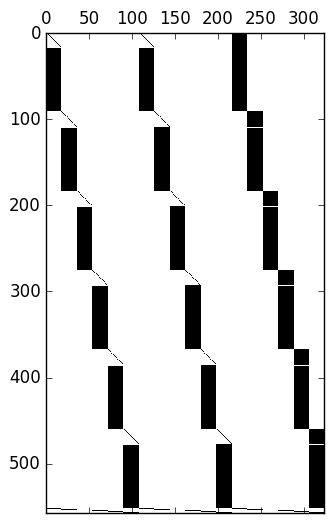

PyObject <matplotlib.image.AxesImage object at 0x7fd95fbd6048>

In [47]:
nb = 200
nnr = 20:10:190
nt = 6

sptimes = Vector{Float64}()
detimes = Vector{Float64}()
qrtimes = Vector{Float64}()

sperr = Vector{Float64}()
deerr = Vector{Float64}()
qrerr = Vector{Float64}()

for nr in nnr
    A = sprand(nb*nt,(nb+nr)*nt,0.3)
    if rank(full(A)) == nb*nt
        tsp = @timed Bsp = kernel_backsubs(A)
        tde = @timed Bde = kernel_backsubs_old(A)
        tqr = @timed Bqr = kernel_basis(A)
    else
        tnsp = 0
        tde = 0
        tqr = 0
    end
    push!(sptimes,tsp[2])
    push!(detimes,tde[2])
    push!(qrtimes,tqr[2])
    push!(sperr,maxabs(A*Bsp))
    push!(deerr,maxabs(A*Bde))
    push!(qrerr,maxabs(A*Bqr))    
    println(nr)
end

In [94]:
using ProgressMeter

nb = 200
nnr = 20:10:190
nt = 6

sptimes = Vector{Float64}()
detimes = Vector{Float64}()
qrtimes = Vector{Float64}()

sperr = Vector{Float64}()
deerr = Vector{Float64}()
qrerr = Vector{Float64}()

p = Progress(length(nnr),1)
for nr in nnr
    A = sprand(nb*nt,(nb+nr)*nt,0.3)
    if rank(full(A)) == nb*nt
        tsp = @timed Bsp = kernel_backsubs(A)
        tde = @timed Bde = kernel_backsubs_old(A)
        tqr = @timed Bqr = kernel_basis(A)
    else
        tnsp = 0
        tde = 0
        tqr = 0
    end
    push!(sptimes,tsp[2])
    push!(detimes,tde[2])
    push!(qrtimes,tqr[2])
    push!(sperr,maxabs(A*Bsp))
    push!(deerr,maxabs(A*Bde))
    push!(qrerr,maxabs(A*Bqr))    
    next!(p)
end

Progress: 100% Time: 0:02:24


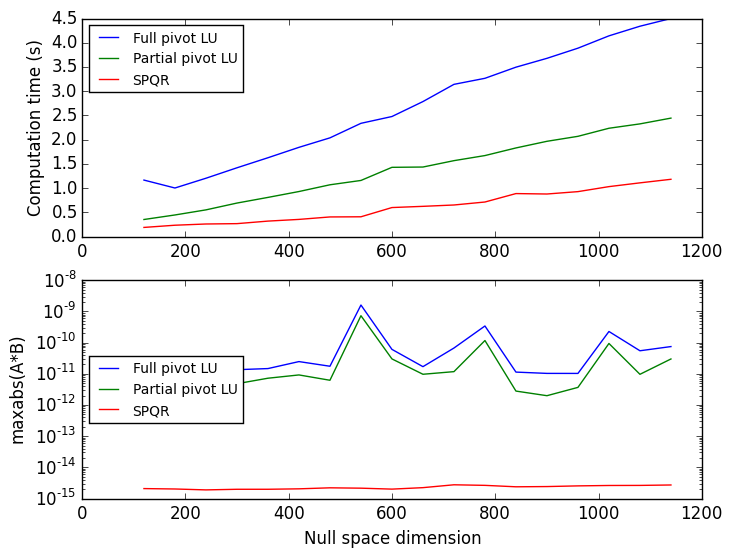

PyObject <matplotlib.text.Text object at 0x7f6910857978>

In [93]:
using PyPlot
PyPlot.svg(true)

subplot(211)
plot(nnr*nt,sptimes)
hold(true)
plot(nnr*nt,detimes)
plot(nnr*nt,qrtimes)
legend(["Full pivot LU";"Partial pivot LU";"SPQR"],fontsize=10,loc=2)
# xlabel("Null space dimension")
ylabel("Computation time (s)")

subplot(212)
semilogy(nnr*nt,sperr)
hold(true)
semilogy(nnr*nt,deerr)
semilogy(nnr*nt,qrerr)
legend(["Full pivot LU";"Partial pivot LU";"SPQR"],fontsize=10,loc=6)
xlabel("Null space dimension")
ylabel("maxabs(A*B)")

Conclusion: sacrifice accuracy to reduce storage requirement. Generally faster, scales better, accuracy about the same. But SPQR is much faster still and scales better than either LU-based method. SPQR is also much more accurate. So the only way LU wins is if I can re-use some of the computation from one QCQP to the next.

$A$ has $(n_b+2)*n_t$ rows and $(n_b+n_r+2)*n_t$ columns.